# Offline Evaluation Analysis

*Warning: This notebook takes a long time processing. Run this only with enough time*

This notebook is used to:
* read prediction-evaluation data.
* make basic transformations.
* make an explorational data analysis.

## The data
The data contents summaries of metrics for unique combinations of the hashtags(case-unsensitive):
* #Trump
* #News
* #FakeNews
* #Democrats
* #Politics
The combination is generated with boolean flags for every hashtag.
If a tweet does not contain any of these hashtags, it links to a valid combination aswell. This combination is therefore '[false,false,false,false,false]'.

Summaries about the last 60 seconds are recorded every second for every unique hashtag combination. If a combination did not occure in this timewindow, no summary is recorded for this combination.

### Used metrics
Following metrics were calculated for every occuring hashtag combination in a timewindow of the last 60 seconds:
* count - The total count of tweets for this combination
* meanTextLength - the mean length of a not truncated tweet (hashtags and mentions included)
* meanHashtagCount - The mean count of hashtags
* meanTrumpCount - The mean occurences of the word 'trump' in the tweet texts; not case-sensitive.
* meanSensitiveCount - The mean count of tweets flagged as "Possibly sensitive". (Flagging performed by Twitter)

These metrics are used to generate a prediction for hashtag combinations w.r.t. the time of the day.

## Used libaries
Make sure those are installed.

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta

### Plotting
And display in notebook.

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (16.0, 9.0)
%matplotlib inline

## Reading history CSV files

In [3]:
# The main working directory
mainDir = ""

evalFile = mainDir + "predictionsEvaluation.csv"

#### Plotfunction definition:

In [4]:
def plotMetric(df,metricName):
    traces = list()
    
    fig = plt.figure(figsize=(16,9))
    ax = plt.axes()

    for i in range(0,len(df)):
        df.plot(y=metricName, kind = 'bar', label=i, ax=ax)
    ax.legend().set_visible(False)

    plt.ylabel(metricName)
    
    plt.title('Mean of Metric: ' + metricName, fontsize=18)

In [5]:
def plotMetricTimeseries(dfList, metricName, timeName = 'timestamp', skip=0, kind = 'line'):
    traces = list()
    
    fig = plt.figure(figsize=(16,9))
    ax = plt.axes()

    for i in range(skip,len(dfList)):
        df = dfList[i]
        df.plot(x=timeName, y=metricName, label=i, ax=ax, linewidth = 0.5, kind = kind)
        
    titleStr= 'Timeseries of Metric: ' + metricName
    
    
    plt.xlabel(timeName)
    plt.ylabel(metricName)
    plt.suptitle('Timeseries of Metric: ' + metricName, fontsize=18)
    
    if(skip>0):
       plt.title('(skipped ' + str(skip) + ' datarows)', fontsize=10)
    
    plt.legend()

In [6]:
def plotErrorHist(df, metricName, bins=500, alpha=1.0, label = "", newFigure = True):
    traces = list()
    
    if(newFigure):
        fig = plt.figure(figsize=(16,9))
        ax = plt.axes()
    
    df[metricName].plot(kind = 'hist', label=label, bins = bins, alpha = alpha)
        
    titleStr = 'Histogram of: ' + metricName
    
    plt.xlabel(metricName)
    plt.title(titleStr, fontsize=18)

In [7]:
def plotErrorHistList(dfList, metricName, bins=200):
    traces = list()
    
    alpha=1/len(dfList)
    
    fig = plt.figure(figsize=(16,9))
    ax = plt.axes()

    for i in range(0,len(dfList)):
        df = dfList[i]
        plotErrorHist(df, metricName, bins=bins, alpha = 0.5, label=i, newFigure=False)
    plt.legend()

Due to the quantity of unique combinations, refer to this table for index-combo linking.

## Predictions Evaluation

#### Read prediction evaluation

In [8]:
predEvaluation = pd.read_csv(evalFile,
                             sep=";", 
                             header = 0)

In [9]:
predEvaluation.columns

Index(['timestamp', 'time', 'isTrumpTweet', 'isNewsTweet', 'isFakeNewsTweet',
       'isDemocratsTweet', 'isPoliticsTweet', 'errorCount',
       'errorMeanTextLength', 'errorMeanHashtagCount', 'errorMeanTrumpCount',
       'errorMeanSensitiveCount'],
      dtype='object')

#### Transformation

In [10]:
# transform timestamp strings to datetime format
predEvaluation['timestamp'] = pd.to_datetime(predEvaluation['timestamp']) + timedelta(hours=1)
predEvaluation['time'] = pd.to_datetime(predEvaluation['time']).apply(lambda x: x.time())

In [11]:
# group by hashtag combination, calculate mean values of metrics
meanEvals = predEvaluation.groupby(['isTrumpTweet',
                                    'isNewsTweet',
                                    'isFakeNewsTweet',
                                    'isDemocratsTweet',
                                    'isPoliticsTweet'])['errorCount',
                                                        'errorMeanTextLength',
                                                        'errorMeanHashtagCount',
                                                        'errorMeanTrumpCount',
                                                        'errorMeanSensitiveCount'].agg(np.mean).reset_index()

In [12]:
evalList = list()
for i in range(0, len(meanEvals)):
    evalList.append(meanEvals.loc[i,['isTrumpTweet','isNewsTweet','isFakeNewsTweet','isDemocratsTweet','isPoliticsTweet']].to_frame().transpose())

In [13]:
evalTimeseriesList = list()
for i in range(0,len(evalList)):
    evalTimeseriesList.append(evalList[i]
                              .merge(predEvaluation,on=['isTrumpTweet',
                                                        'isNewsTweet',
                                                        'isFakeNewsTweet',
                                                        'isDemocratsTweet',
                                                        'isPoliticsTweet']))

### Index
Due to the quantity of unique combinations, refer to this table while reading the plots and it's legends.

In [14]:
meanEvals[['isTrumpTweet',
           'isNewsTweet',
           'isFakeNewsTweet',
           'isDemocratsTweet',
           'isPoliticsTweet']]

,isTrumpTweet,isNewsTweet,isFakeNewsTweet,isDemocratsTweet,isPoliticsTweet
0,False,False,False,False,False
1,False,False,False,False,True
2,False,False,False,True,False
3,False,False,True,False,False
4,False,True,False,False,False
5,False,True,False,False,True
6,False,True,True,False,False
7,True,False,False,False,False
8,True,False,False,False,True
9,True,False,False,True,False


# Plots
In general, the purpose of this section is to visualize the error of our prediction. By this, we can decide if a simple calculation of a mean value is sufficient to predict this metric.

### Barplots
We plot the basic mean errors of each metric for each combination for first insights.

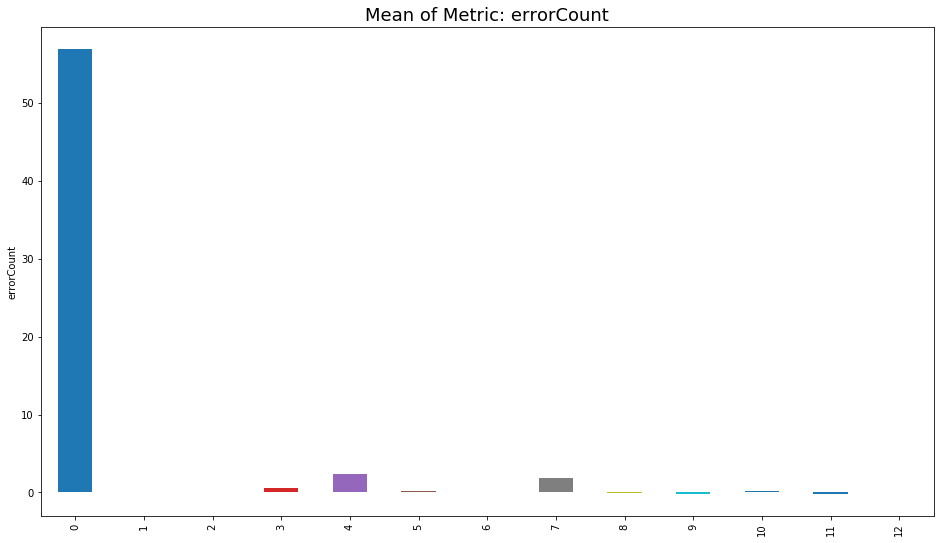

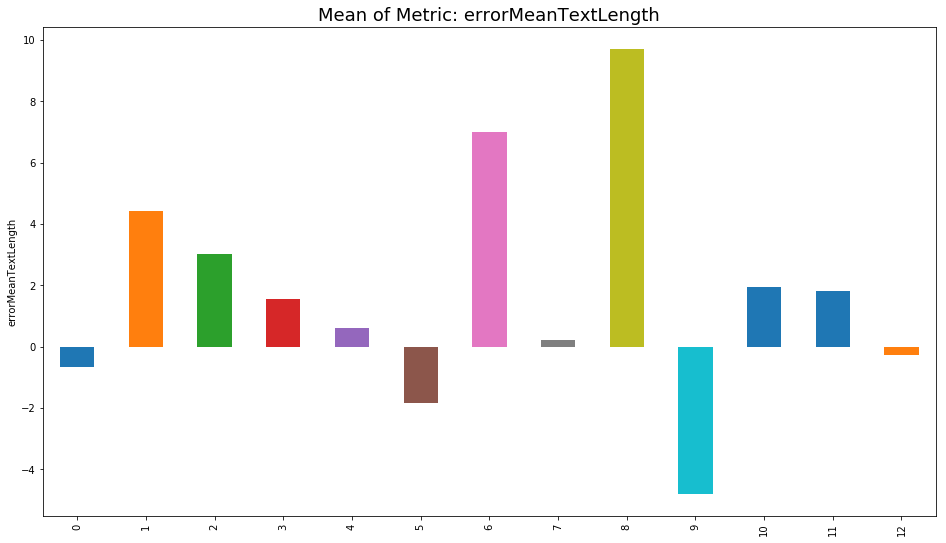

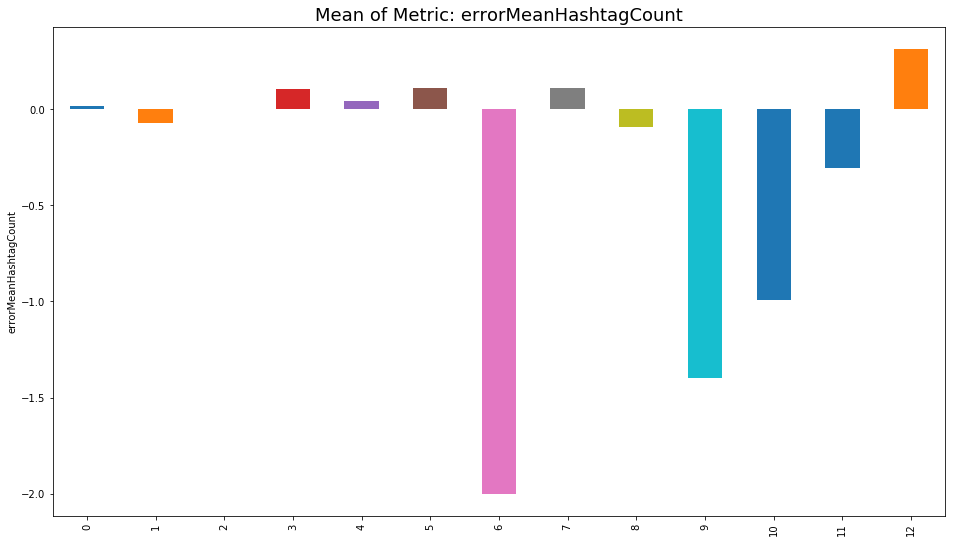

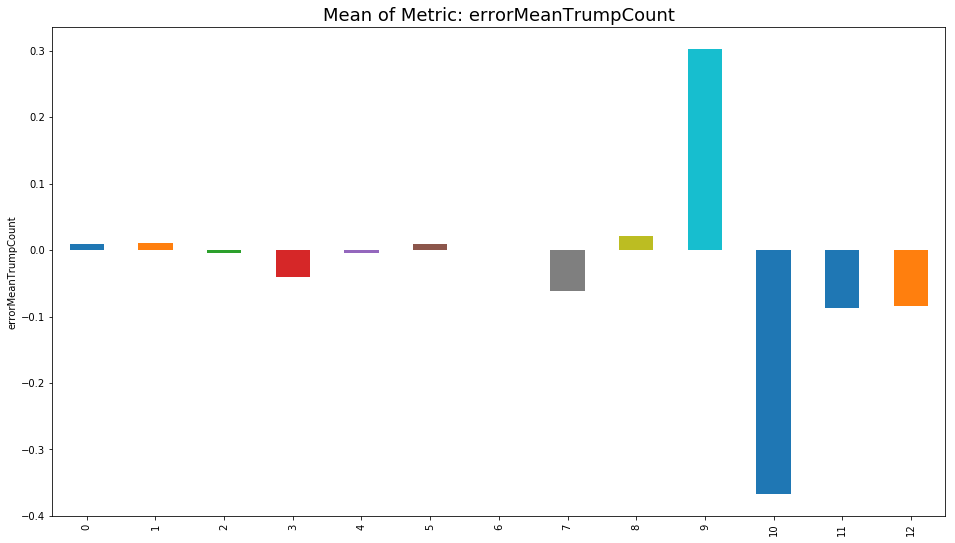

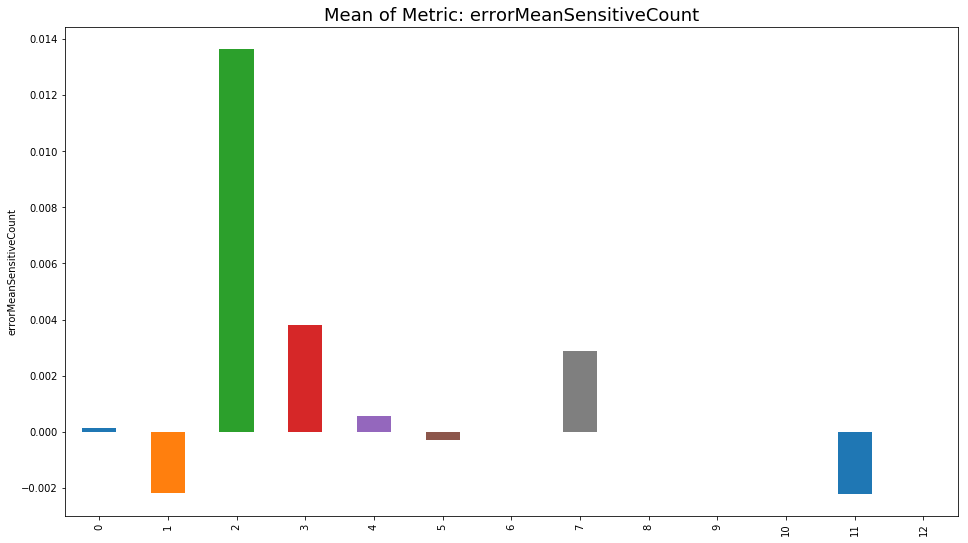

In [15]:
plotMetric(meanEvals, 'errorCount')
plotMetric(meanEvals, 'errorMeanTextLength')
plotMetric(meanEvals, 'errorMeanHashtagCount')
plotMetric(meanEvals, 'errorMeanTrumpCount')
plotMetric(meanEvals, 'errorMeanSensitiveCount')

### Timeseries plots
Zero values are always times, when the Spark application was not active. 

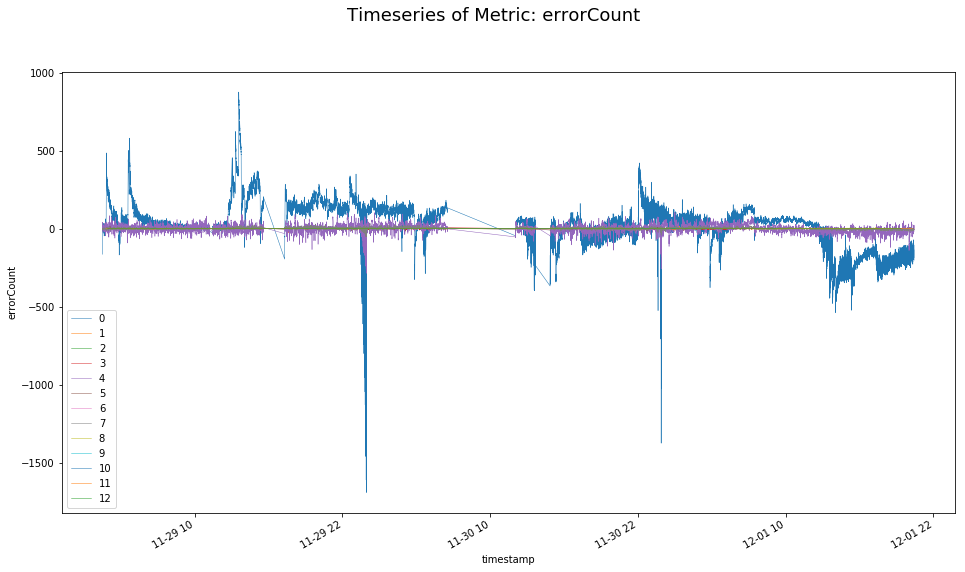

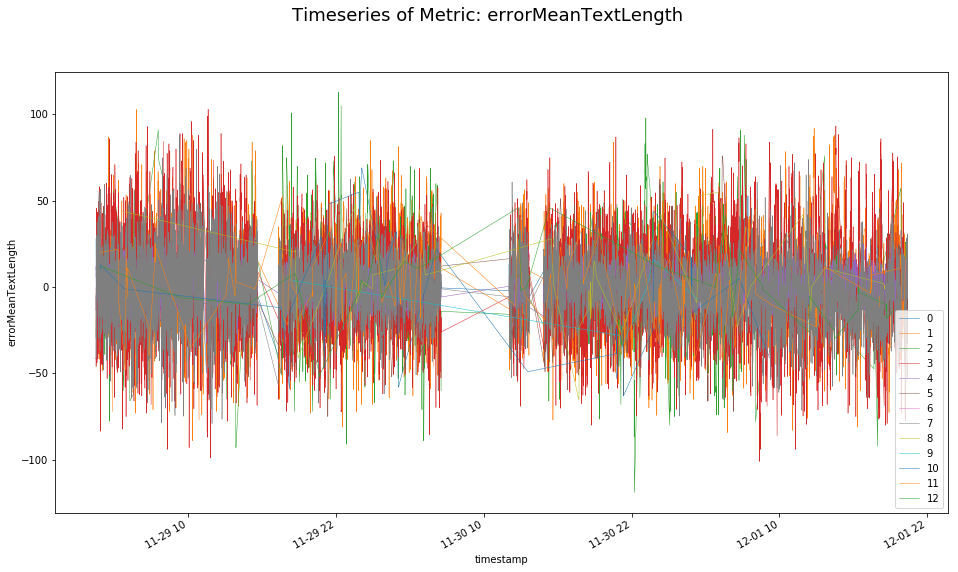

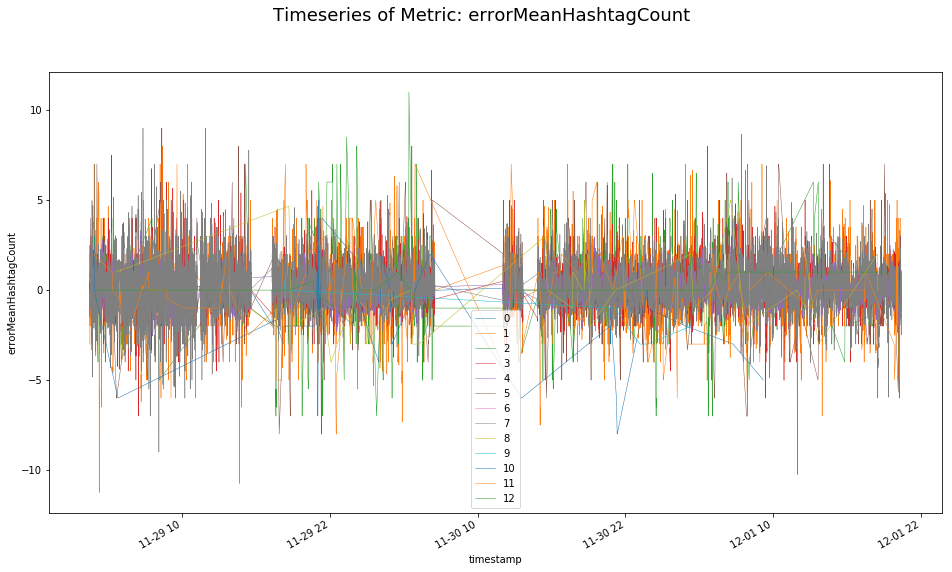

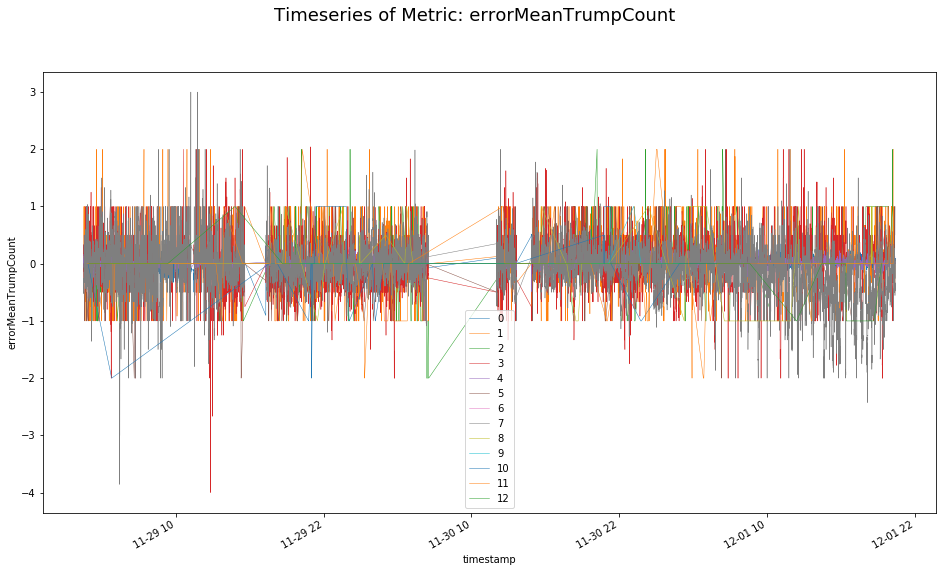

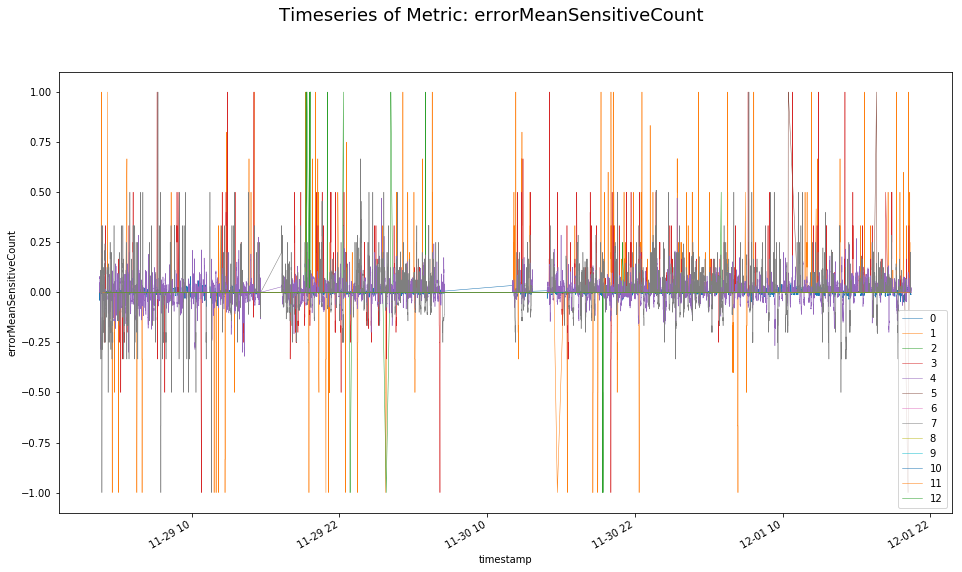

In [16]:
plotMetricTimeseries(evalTimeseriesList, 'errorCount')
plotMetricTimeseries(evalTimeseriesList, 'errorMeanTextLength')
plotMetricTimeseries(evalTimeseriesList, 'errorMeanHashtagCount')
plotMetricTimeseries(evalTimeseriesList, 'errorMeanTrumpCount')
plotMetricTimeseries(evalTimeseriesList, 'errorMeanSensitiveCount')

### Histograms
For prediction evaluation it is interesting to use histograms. By the width of the error distribution we can identify good or bad prediction mechanics.

We do this for all combinations together and seperately.

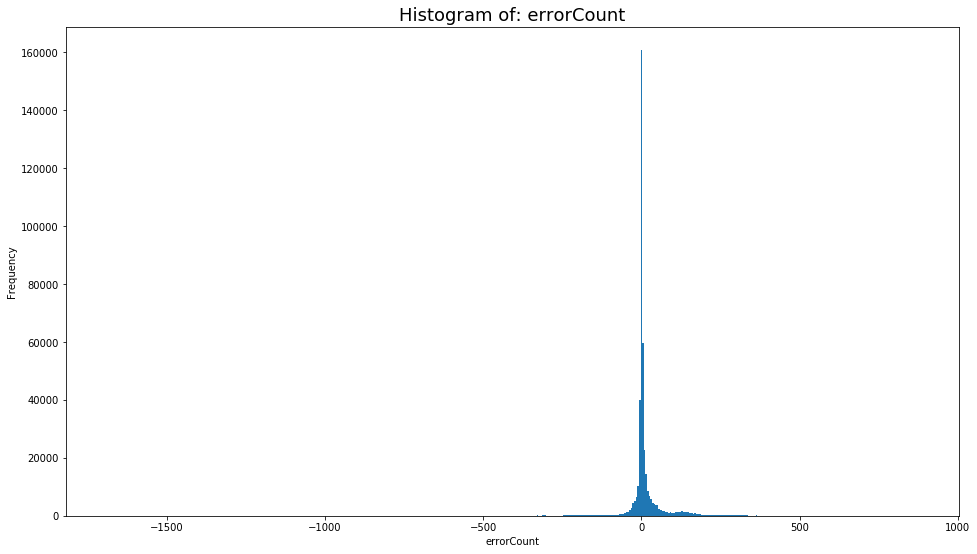

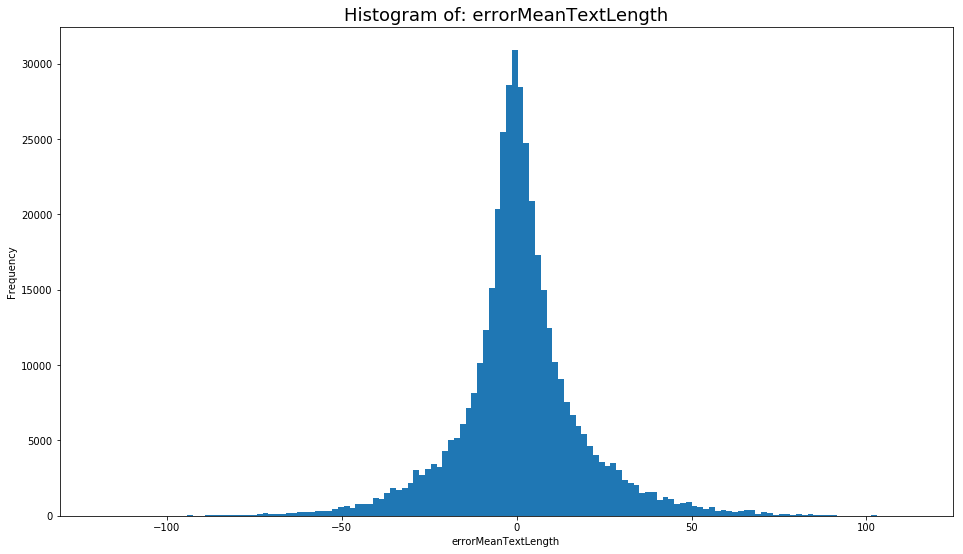

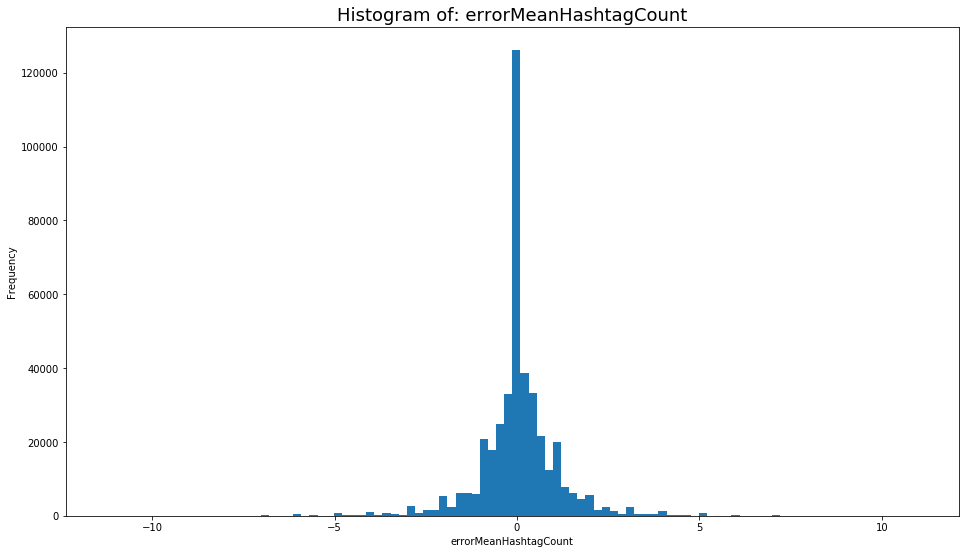

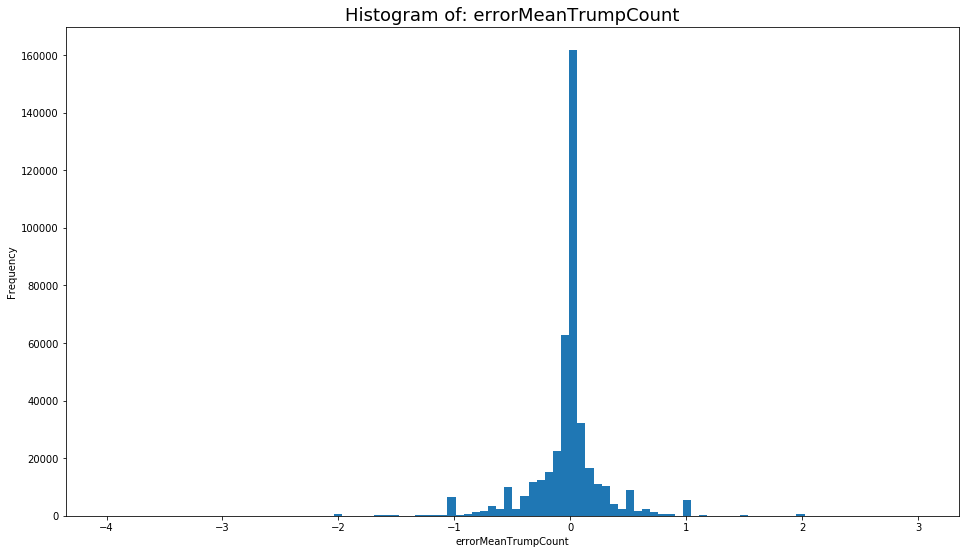

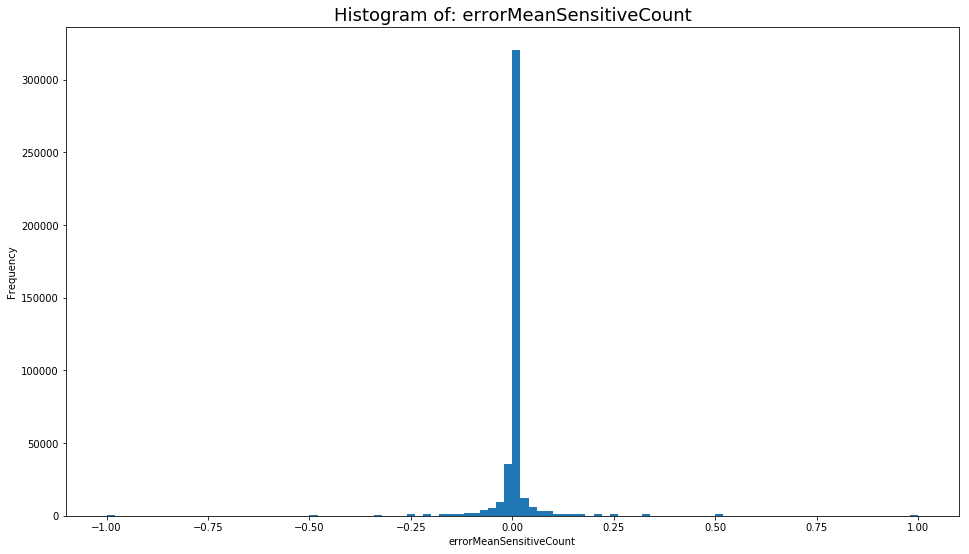

In [17]:
plotErrorHist(predEvaluation, 'errorCount', bins=500)
plotErrorHist(predEvaluation, 'errorMeanTextLength', bins=140)
plotErrorHist(predEvaluation, 'errorMeanHashtagCount', bins=100)
plotErrorHist(predEvaluation, 'errorMeanTrumpCount', bins=100)
plotErrorHist(predEvaluation, 'errorMeanSensitiveCount', bins=100)

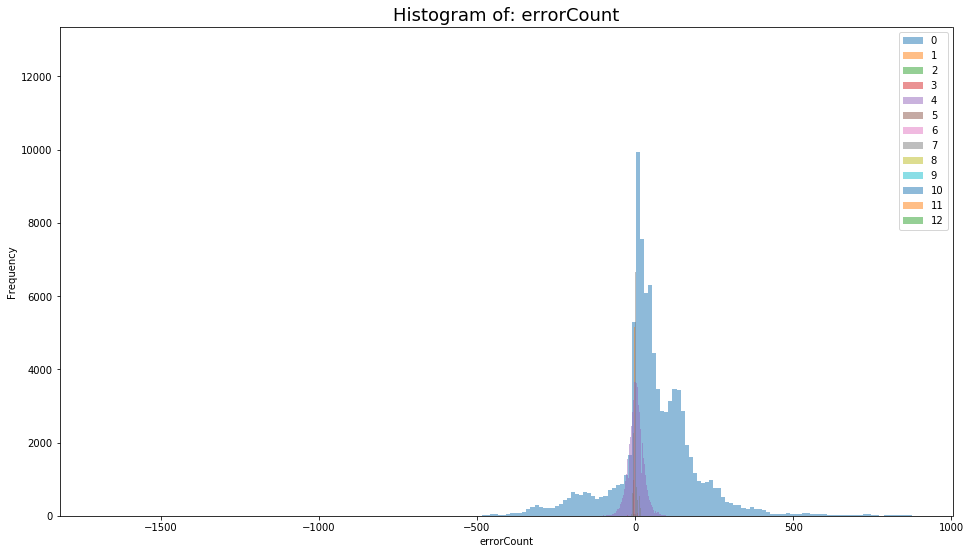

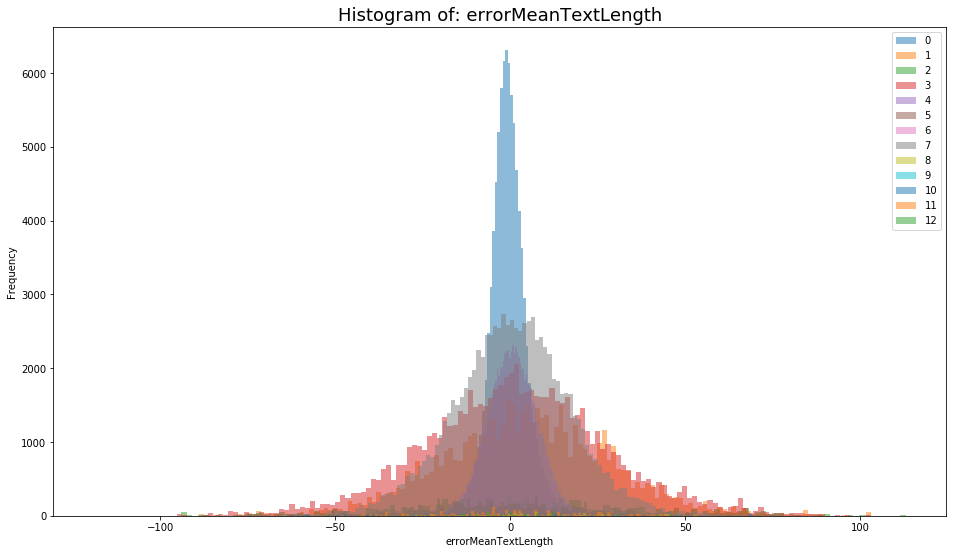

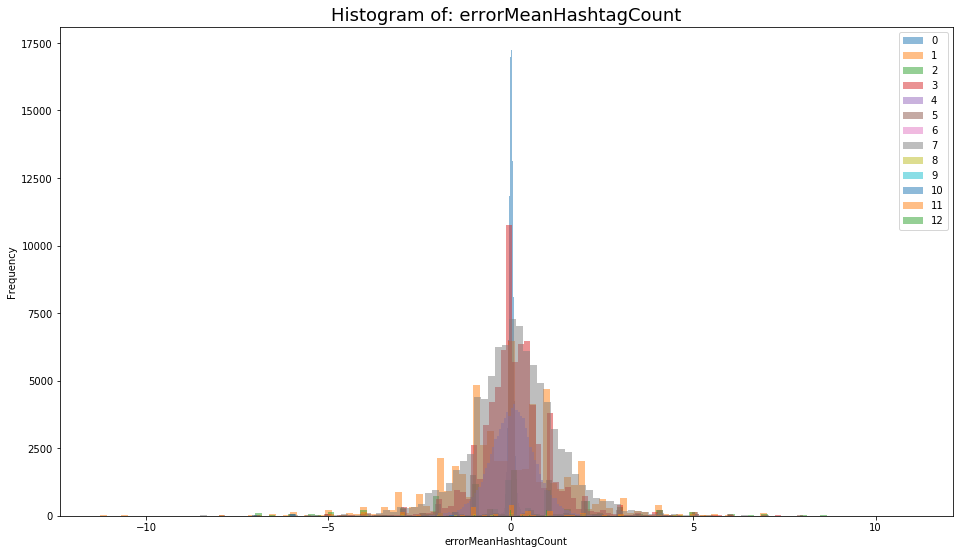

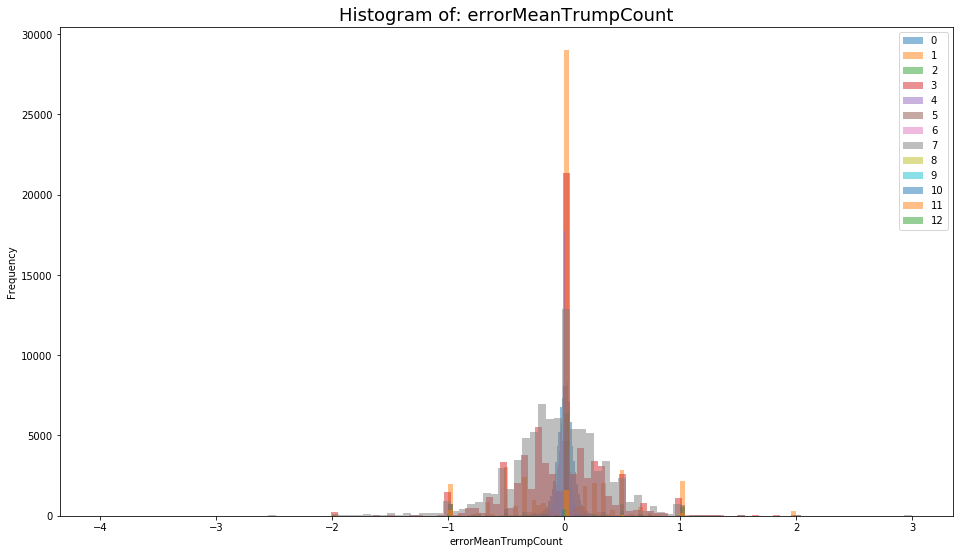

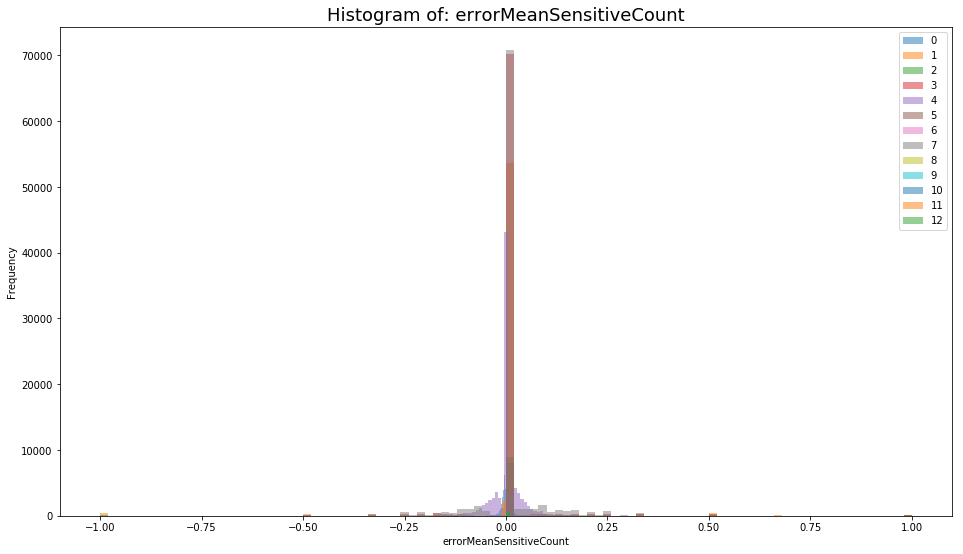

In [18]:
plotErrorHistList(evalTimeseriesList, 'errorCount', bins=200)
plotErrorHistList(evalTimeseriesList, 'errorMeanTextLength', bins=140)
plotErrorHistList(evalTimeseriesList, 'errorMeanHashtagCount', bins=100)
plotErrorHistList(evalTimeseriesList, 'errorMeanTrumpCount', bins=100)
plotErrorHistList(evalTimeseriesList, 'errorMeanSensitiveCount', bins=100)